# Assignment 1: Part D
### Yifan Li
### A1948864

In [37]:
import sys

print("Python version:", sys.version.split()[0])

Python version: 3.12.7


# 1. Load the Data
This file contains two datasets that I downloaded from the website. They have been merged by date.

In [38]:
import pandas as pd
import numpy as np

# Load the merged weather and transport data
file = "Canberra_Merged_Weather_Transport.csv"
df = pd.read_csv(file)
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1918 entries, 0 to 1917
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                1918 non-null   object 
 1   Weather_Code        1918 non-null   int64  
 2   Max_Temp_C          1918 non-null   float64
 3   Min_Temp_C          1918 non-null   float64
 4   Mean_Temp_C         1918 non-null   float64
 5   Precipitation_mm    1918 non-null   float64
 6   Rain_mm             1918 non-null   float64
 7   Precip_Hours        1918 non-null   float64
 8   Daylight_sec        1918 non-null   float64
 9   Sunshine_sec        1918 non-null   float64
 10  Max_Wind_Speed_mps  1918 non-null   float64
 11  Local Route         1918 non-null   int64  
 12  Light Rail          1918 non-null   int64  
 13  Peak Service        1918 non-null   int64  
 14  Rapid Route         1918 non-null   int64  
 15  School              1918 non-null   int64  
 16  Other 

# 2. Data Cleaning

In [39]:
# Convert data types to the right type
df['Date'] = pd.to_datetime(df['Date'])
df['Weather_Code'] = df['Weather_Code'].astype('category')

# Fill missing values
df['School'] = df['School'].fillna(0)
df['Other'] = df['Other'].fillna(0)

# Calculate total passengers
df['Total_Passengers'] = (
    df['Local Route'] + df['Light Rail'] + df['Peak Service'] +
    df['Rapid Route'] + df['School'].fillna(0) + df['Other'].fillna(0)
)

# Create weekday and weekend flags
df['Weekday'] = df['Date'].dt.dayofweek
df['Is_Weekend'] = df['Weekday'].isin([5, 6])

# 3. Data Visualisation

## 3.1 Correlation Heatmap

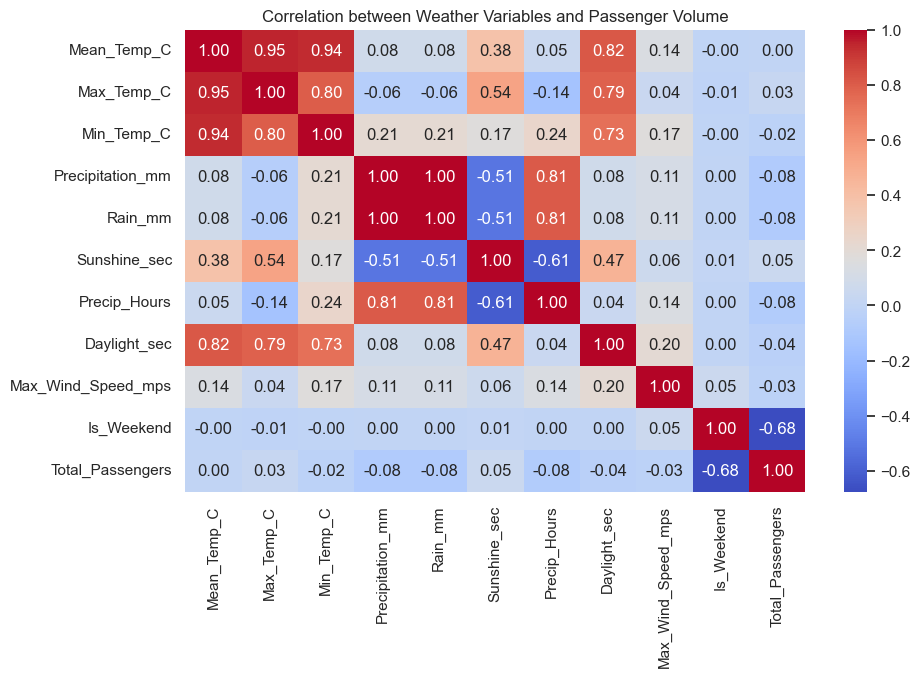

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant columns
selected_cols = [
    'Mean_Temp_C', 'Max_Temp_C', 'Min_Temp_C', 'Precipitation_mm', 'Rain_mm',
    'Sunshine_sec', 'Precip_Hours', 'Daylight_sec', 'Max_Wind_Speed_mps',
    'Is_Weekend', 'Total_Passengers'
]

# Compute correlation matrix
corr_matrix = df[selected_cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation between Weather Variables and Passenger Volume")
plt.show()

## 3.2 Relationship between various variables and patronage

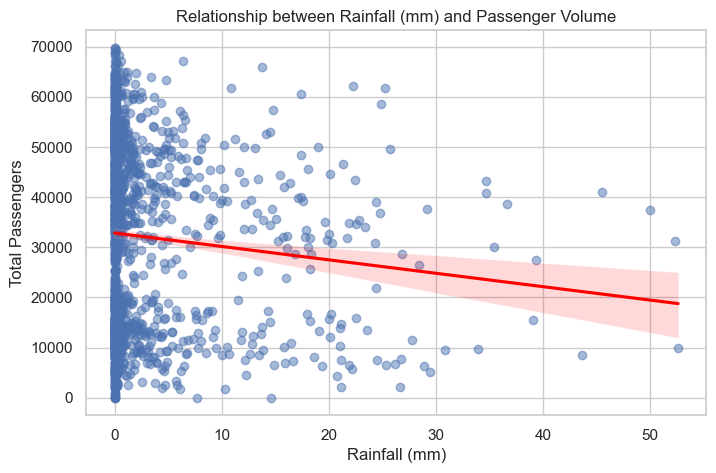

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Rainfall vs Passenger Volume
plt.figure(figsize=(8,5))
sns.regplot(x='Rain_mm', y='Total_Passengers', data=df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Relationship between Rainfall (mm) and Passenger Volume')
plt.xlabel('Rainfall (mm)')
plt.ylabel('Total Passengers')
plt.show()


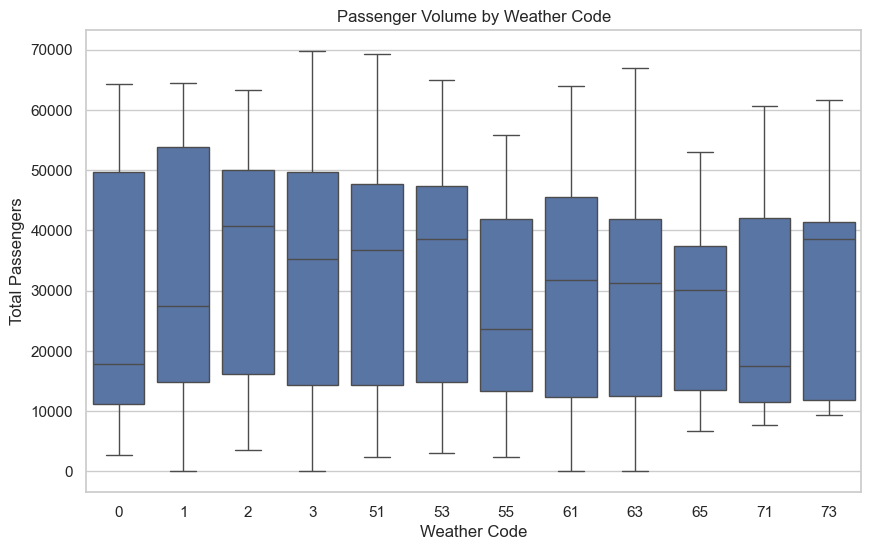

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Weather Code vs Passenger Volume
plt.figure(figsize=(10, 6))
sns.boxplot(x='Weather_Code', y='Total_Passengers', data=df)
plt.title("Passenger Volume by Weather Code")
plt.xlabel("Weather Code")
plt.ylabel("Total Passengers")
plt.show()

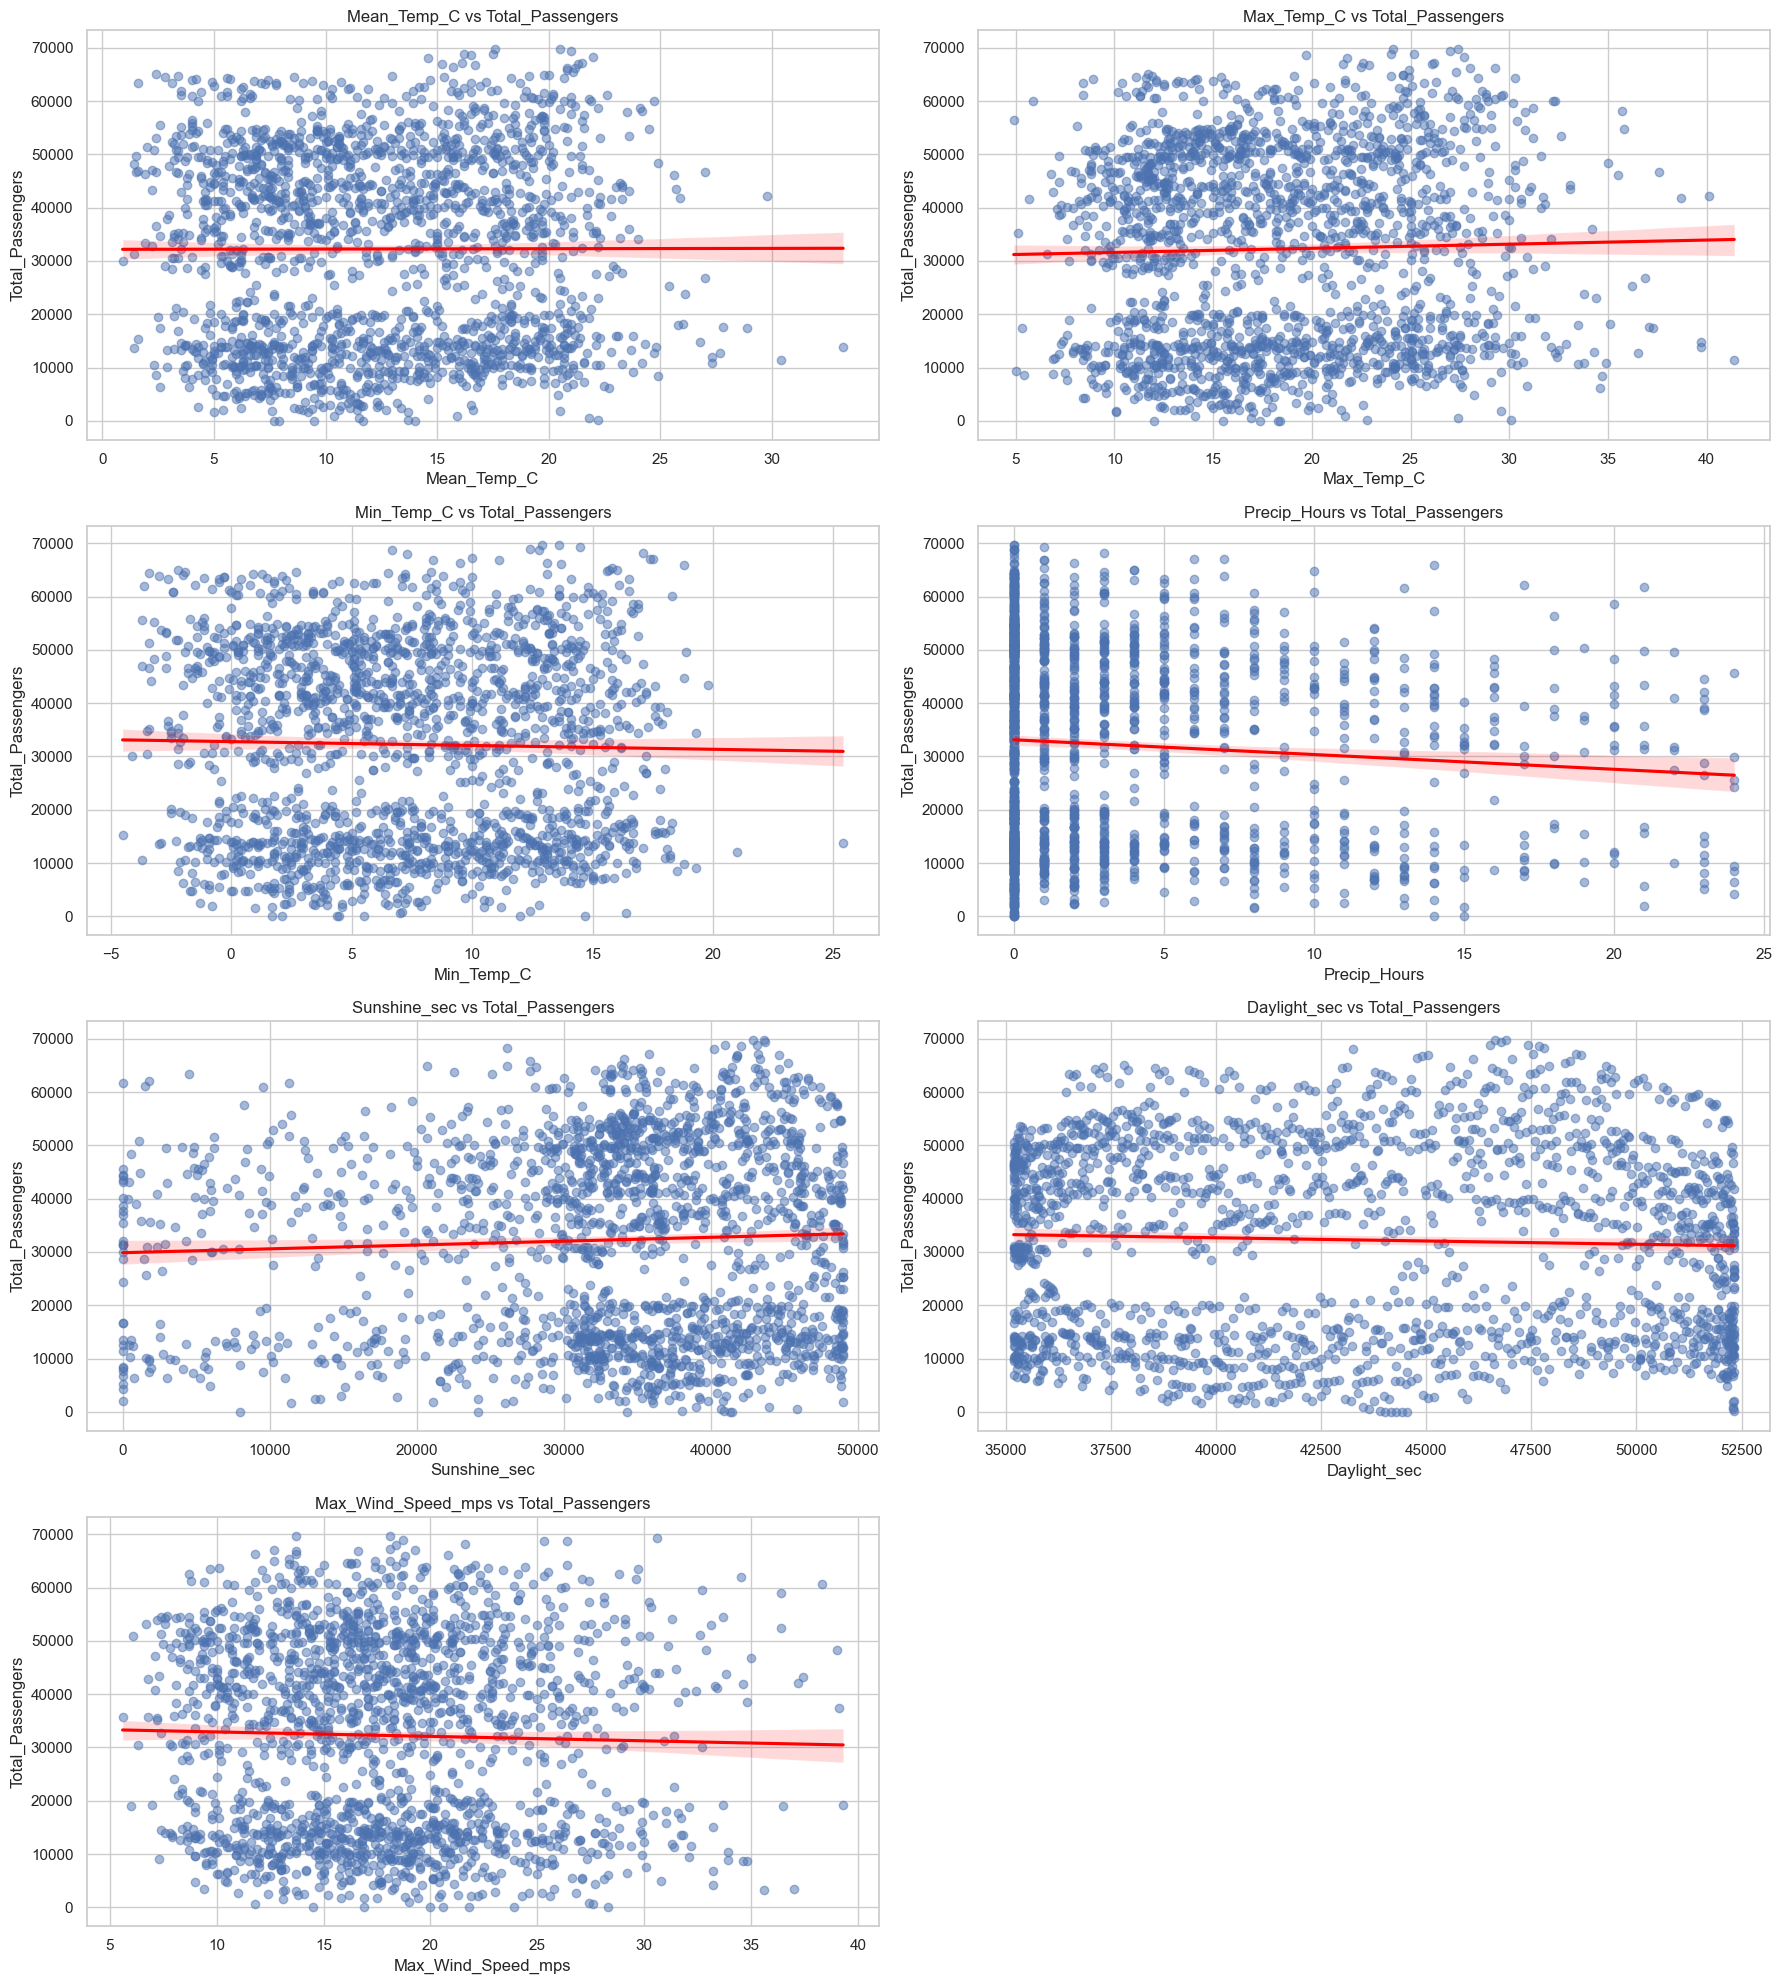

In [43]:
# Other Weather variables to plot
weather_vars = [
    'Mean_Temp_C', 'Max_Temp_C', 'Min_Temp_C', 'Precip_Hours',
    'Sunshine_sec', 'Daylight_sec', 'Max_Wind_Speed_mps'
]

sns.set(style="whitegrid")
n_cols = 2
n_rows = -(-len(weather_vars) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, var in enumerate(weather_vars):
    sns.regplot(
        x=var, y='Total_Passengers', data=df, ax=axes[i],
        scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'}
    )
    axes[i].set_title(f"{var} vs Total_Passengers")
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# 4. Data Preprocessing

In [44]:
df = df.sort_values('Date')
df.fillna(method='ffill', inplace=True)

# # Select features and target
features = [
    'Max_Temp_C', 'Min_Temp_C', 'Mean_Temp_C',
    'Precipitation_mm', 'Rain_mm', 'Precip_Hours',
    'Daylight_sec', 'Sunshine_sec', 'Max_Wind_Speed_mps',
    'Weekday'
]

target = 'Total_Passengers'
data = df[features + [target]].values

C:\Users\11849\AppData\Local\Temp\ipykernel_11796\1133407339.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [45]:
n_steps = 7
X_seq, y_seq = [], []

# # Generate sequences for LSTM
for i in range(len(data) - n_steps):
    X_seq.append(data[i:i + n_steps])
    y_seq.append(data[i + n_steps, -1])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

In [46]:
from sklearn.model_selection import train_test_split

# Split the data (80% train, 20% test)
split_index = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_index], X_seq[split_index:]
y_train, y_test = y_seq[:split_index], y_seq[split_index:]

In [47]:
from sklearn.preprocessing import StandardScaler

# Scale the features and target

n_samples, time_steps, n_features = X_train.shape

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, n_features)).reshape(n_samples, time_steps, n_features)
X_test_scaled = scaler.transform(X_test.reshape(-1, n_features)).reshape(X_test.shape)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

# 5. Model Training and Testing
Here, we directly display the model with the best results.

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(n_steps, X_seq.shape[2])))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

c:\Users\11849\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,569 (84.25 KB)

 Trainable params: 21,569 (84.25 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# Train the model

history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    shuffle=False, 
    verbose=1
)

Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.4376 - val_loss: 0.9072
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1711 - val_loss: 0.7456
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8840 - val_loss: 0.5838
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6326 - val_loss: 0.4127
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4423 - val_loss: 0.3115
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3336 - val_loss: 0.2823
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2820 - val_loss: 0.2954
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3101 - val_loss: 0.2620
Epoch 9/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2394 - val_loss: 0.1697
Epoch 10/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1479 - val_loss: 0.1434
Epoch 11/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1251 - val_loss: 0.1523
Epoch 12/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1152 - val_lo

In [50]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict and inverse scale
y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")
# Since no random number seed has been set, this result will be slightly biased.

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 7332.30
R² Score: 0.8266


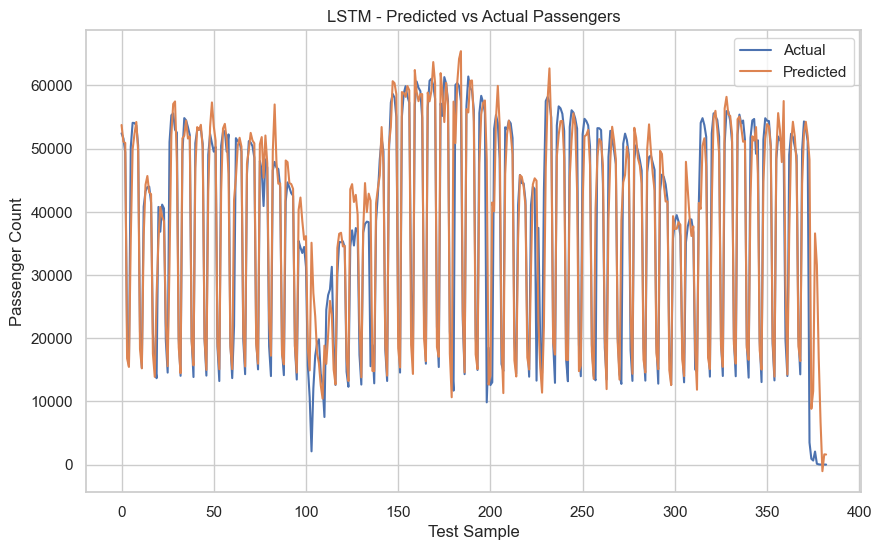

In [51]:
import matplotlib.pyplot as plt

# Plot actual data vs predicted data
plt.figure(figsize=(10,6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("LSTM - Predicted vs Actual Passengers")
plt.xlabel("Test Sample")
plt.ylabel("Passenger Count")
plt.legend()
plt.show()